In [9]:
## Import and data sources
import numpy as np                              # version: 1.17.2
import pandas as pd                             # version: 1.0.5
import urllib.request as req                    # version: 3.6
import ast
import sklearn.model_selection as ms            # version: 0.21.3
from sklearn.preprocessing import MinMaxScaler  # version: 0.21.3
import xgboost as xgb                           # version: 1.0.2
import shap                                     # version: 0.34.0
import matplotlib.pyplot as plt                 # version: 2.2.3
import seaborn as sns                           # version: 0.9.0
import sys
import os

# To supress warnings from shap
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
N_THREADS = 88  ## NOTE: The number of threads for parallel runs. Modify as needed.
os.environ['OMP_NUM_THREADS'] = str(N_THREADS)
    
sns.set(font_scale=1.25, style='white')

census_key = 'a4feafd1e894848eda9a783376cf7977222aecd2' ## The key from https://www.census.gov/data/developers.html "Request a key".

# APIs from the US Census Bureau
population_density_url = 'https://api.census.gov/data/2019/pep/population?get=DENSITY&in=state:*&for=county:*&key={}'.format(census_key)
above_65_url = 'https://api.census.gov/data/2018/acs/acs5/subject?get=GEO_ID,NAME,S0101_C02_030E&in=state:*&for=county:*&key={}'.format(census_key)
transport_url = 'https://api.census.gov/data/2018/acs/acs5?get=GEO_ID,NAME,B08006_001E,B08006_003E,B08006_017E&in=state:*&for=county:*&key={}'.format(census_key)
race_url = 'https://api.census.gov/data/2018/acs/acs5/profile?get=GEO_ID,NAME,DP05_0070E,DP05_0077E&in=state:*&for=county:*&key={}'.format(census_key)
poverty_url = 'https://api.census.gov/data/2018/acs/acs5/subject?get=GEO_ID,NAME,S1701_C03_001E&in=state:*&for=county:*&key={}'.format(census_key)
income_url = 'https://api.census.gov/data/2018/acs/acs5/subject?get=GEO_ID,NAME,S1902_C03_019E&in=state:*&for=county:*&key={}'.format(census_key)
employed_url = 'https://api.census.gov/data/2018/acs/acs5/subject?get=GEO_ID,NAME,S2301_C03_001E&in=state:*&for=county:*&key={}'.format(census_key)
unemployment_url = 'https://api.census.gov/data/2018/acs/acs5/subject?get=GEO_ID,NAME,S2301_C04_001E&in=state:*&for=county:*&key={}'.format(census_key)
mean_commute_url = 'https://api.census.gov/data/2018/acs/acs5/subject?get=GEO_ID,NAME,S0801_C01_046E&in=state:*&for=county:*&key={}'.format(census_key)
labour_url = 'https://api.census.gov/data/2018/acs/acs5/profile?get=GEO_ID,NAME,DP03_0028PE,DP03_0030PE,DP03_0031PE&in=state:*&for=county:*&key={}'.format(census_key)
insurance_url = 'https://api.census.gov/data/2018/acs/acs5/profile?get=GEO_ID,NAME,DP03_0099PE&in=state:*&for=county:*&key={}'.format(census_key)

# links to the JHU GitHub
jhu_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
jhu_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'

In [2]:
def runBDT(df, type=0, scale=False, n_run=100):
    ''' A function to run the ensemble of BDT based on XGBoost
        arguments:
            df: the dataframe with the features and labels
            type:
                0: death rate
                1: confirmed case rate
                2: fatality rate
            scale: boolean to toggle scaling of the features
            n_run: The number of BDTs in an ensemble
        return:
            shap_values: the array of SHAP values
            X_shap: The feature array used to evaluate the SHAP values
    '''
    df_orig = df.copy(deep=True)
    
    # slice the dataframe for the type to be analyzed and scale if necessary
    if scale:
        # df.Density = 10**df.Density
        if type == 0: df_temp = df.pop('death rate')
        if type == 1: df_temp = df.pop('confirmed rate')
        if type == 2: df_temp = df.pop('fatality rate')
        scaler = MinMaxScaler()
        df = pd.DataFrame(scaler.fit_transform(df))
        df.columns = df_orig.columns[:-1]
        df.index = df_orig.index
        df = pd.concat([df, df_temp], axis=1)
    if type == 0:
        X = df.drop(columns=['death rate'])
        y = df['death rate'].values
        X_shap = pd.DataFrame(X.values, columns=df.drop(columns=['death rate']).columns)
    elif type == 1:
        X = df.drop(columns=['confirmed rate'])
        y = df['confirmed rate'].values
        X_shap = pd.DataFrame(X.values, columns=df.drop(columns=['confirmed rate']).columns)
    elif type == 2: # have to make this work
        df.dropna(inplace=True)
        df.drop(df[df['fatality rate']==np.inf].index, inplace=True)
        X = df.drop(columns=['fatality rate'])
        y = df['fatality rate'].values
        X_shap = pd.DataFrame(X.values, columns=df.drop(columns=['fatality rate']).columns)

    N = n_run
    acc_list = np.array([0.]*N)
    shap_values = None

    # the loop for running the ensemble of BDT and compute the SHAP values
    for n in range(N):
        x_train, x_test, y_train, y_test = ms.train_test_split(X.values, y, test_size=0.5)

        regressor = xgb.XGBRegressor(learning_rate=0.01, subsample=1., colsample_bytree=1., n_estimators=500, max_depth=3, nthread=N_THREADS)
        regressor = regressor.fit(x_train, y_train)
        acc_list[n] = regressor.score(x_test, y_test)*100
        explainer = shap.TreeExplainer(regressor, feature_perturbation='tree_path_dependent')
        if shap_values is None:
            shap_values = explainer.shap_values(X_shap)
        else:
            shap_values += explainer.shap_values(X_shap)
    shap_values /= N
    print('Accuracy Score: {:2.2f}% +/- {:2.2f}%'.format(round(acc_list.mean(),2), round(acc_list.std(),2)))
    
    # Violin Plot
    shap.summary_plot(shap_values, X_shap, plot_type="violin", plot_size=(9,6), show=False)
    ax = plt.gca()
    ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
    vals = ax.get_xticks()
    ax.tick_params(labelsize=15)
    for tick in vals:
        ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#808080', zorder=1)
    
    return shap_values, X_shap

def sectorAnalyze(df, df_c, useDensity=False, type=0, scale=False, N=100, run_BDT=True):
    ''' A function to prepare the data for the BDT analysis
        arguments:
            df: the dataframe for the socio-economic conditions
            df_c: the dataframe for covid-19 prevalence
            useDensity: boolean to determine whether density is used in the analysis
            type:
                0: death rate
                1: confirmed case rate
                2: fatality rate
            scale: boolean to toggle scaling of the features
            N: The number of BDTs in an ensemble
            run_BDT: boolean to determin whether to call run_BDT() after cleaning the data
        return:
            df: the combined dataframe
    '''
    df = pd.merge(df, df_c, on='FIPS')
    if type == 0: df['death rate'] = np.log10((df['deaths']) / df['Population'] * 100000. + 1.)
    if type == 1: df['confirmed rate'] = np.log10((df['confirmed']) / df['Population'] * 100000. + 1.)
    if type == 2: df['fatality rate'] = np.log10((df['deaths']) / df['confirmed'] * 100. + 1.)
    if useDensity: df.drop(columns=['FIPS', 'Population', 'deaths', 'confirmed'], inplace=True)
    else: df.drop(columns=['FIPS', 'Population', 'deaths', 'confirmed', 'Density'], inplace=True)

    if run_BDT: return runBDT(df, type=type, scale=scale, n_run=N)
    else: return df

def makeCorrelationPlot(df, cbar=False):
    ''' A function to make the correlation plot using sns
        arguments:
            df: the dataframe to make the plot from
            cbar: boolean to decide whether to plot the colourbar
        return:
            fig: the figure
            ax: the axes
    '''
    fig, ax = plt.subplots(figsize=(15.5, 13))
    mask = np.zeros((df.shape[1],df.shape[1]))
    mask[np.triu_indices_from(mask)] = True
    np.fill_diagonal(mask,0)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    cbar_kws = {"aspect": 50, "ticks": [-1.0,-0.8,-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8,1.0]}
    sns.heatmap(round(df.corr(method='pearson'), 2)+0., mask=mask, annot=True, cmap=cmap, vmin=-1.0, vmax=1.0, cbar_kws=cbar_kws, cbar=cbar)
    return fig, ax

def abs_shap(df_shap, df):
    ''' A function to plot the bar plot for the mean abs SHAP values
        arguments:
            df_shap: the dataframe of the SHAP values
            df: the dataframe for the feature values for which the SHAP values have been determined
    '''
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)

    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'#da3b46','#3f7f93')

    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(9,6),legend=False, zorder=2)
    ax.set_xlabel("Mean(|SHAP Value|) (Red = Positive Impact, Blue = Negative Impact)")
    ax.set_ylabel('')
    # Switch off ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
    # Draw vertical axis lines
    vals = ax.get_xticks()
    for tick in vals:
        ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#808080', zorder=1)
    
def get_census_data(url):
    ''' A function to get the data from USA Census Bureau
        arguments:
            url: the url for the API call
        return:
            df: the dataframe with the pulled data
    '''
    df = pd.DataFrame(ast.literal_eval(req.urlopen(req.Request(url)).read().decode('utf8').replace('null', '"1"')))
    df.columns = df.iloc[0]
    df = df[1:]
    df['FIPS'] = df.pop('GEO_ID').apply(lambda x: int(x[-5:]))
    return df

In [3]:
## The density data from census.gov. We are removing the counties with density = 0 (Puerto Rico)
density = pd.DataFrame(ast.literal_eval(req.urlopen(req.Request(population_density_url)).read().decode('utf8').replace('null', '"0"')))
density.columns = density.iloc[0]
density = density[1:]
density.DENSITY = density.DENSITY.astype('float32')
density.state = density.state.astype('string')
density.county = density.county.astype('string')
density['FIPS'] = density['state'] + density['county']
density.FIPS = density.FIPS.astype('int32')
density = density.drop(labels=['state', 'county'], axis=1)
columns = density.columns.tolist()
columns = columns[::-1]
density = density[columns]
density.drop(density[density['DENSITY'] == 0].index , inplace=True)
density.DENSITY = np.log10(density.DENSITY)
density.rename(columns={'DENSITY': 'Density'}, inplace=True)

In [4]:
## The JHU data
deaths = pd.read_csv(jhu_deaths)
deaths.drop(deaths[(deaths['FIPS'] < 1000) | (deaths['FIPS'] > 57000)].index , inplace=True)
deaths.dropna(inplace=True)

confirmed = pd.read_csv(jhu_confirmed)
confirmed.drop(confirmed[(confirmed['FIPS'] < 1000) | (confirmed['FIPS'] > 57000)].index , inplace=True)
confirmed.dropna(inplace=True)

deaths_df = deaths[['FIPS', 'Population', '8/16/20']]
confirmed_df = confirmed[['FIPS', '8/6/20', '8/16/20']]

## Death rate computation with the JHU data
df_covid19 = deaths_df.copy()
df_covid19.rename(columns={df_covid19.columns[-1]: 'deaths'}, inplace=True)
df_covid19['confirmed'] = confirmed_df['8/6/20']
df_covid19.dropna(inplace=True)
df_covid19.reset_index(drop=True, inplace=True)

## Cleaning out low statistics data and merging JHU with density data
df_cut = df_covid19.drop(df_covid19[(df_covid19['confirmed'] < 1) & (df_covid19['deaths'] < 1)].index)
df_cut.reset_index(drop=True, inplace=True)

In [5]:
# The FIPS and state names
df_census = get_census_data(above_65_url)
df_census = df_census[['FIPS', 'NAME']]
df_census['State'] = df_census.pop('NAME').str.split(', ').str[1]
df_census = df_census.sort_values(df_census.columns[0], ignore_index=True)
df_census = pd.merge(df_census, density, on='FIPS')

# 2018 5 year ACS data on Age
dft = get_census_data(above_65_url)
dft = dft[['FIPS', 'S0101_C02_030E']]
dft.rename(columns={'S0101_C02_030E': 'Senior Citizen'}, inplace=True)
df_census = pd.merge(df_census, dft, on='FIPS')
df_census['Senior Citizen'] = df_census['Senior Citizen'].apply(lambda x: float(x))/100.

# 2018 5 year ACS data on transport used
dft = get_census_data(transport_url)
dft['Transit-1'] = 1. - (dft['B08006_003E'].astype('float')+dft['B08006_017E'].astype('float'))/dft['B08006_001E'].astype('float')
dft = dft[['FIPS', 'Transit-1']]
df_census = pd.merge(df_census, dft, on='FIPS')
df_census['Transit'] = df_census.pop('Transit-1')
df_census.at[df_census[df_census['FIPS']==35039].index, 'Transit'] = 0.159 ## Imputed value from 2011 since values are null in 2018

# 2018 5 year ACS data on non-white
dft = get_census_data(race_url)
# dft['Non-White'] = 1. - dft['B02001_002E'].astype('float')/dft['B02001_001E'].astype('float')
dft['Non-White'] = 1. - dft['DP05_0077E'].astype('float')/dft['DP05_0070E'].astype('float')
dft = dft[['FIPS', 'Non-White']]
df_census = pd.merge(df_census, dft, on='FIPS')

# 2018 5 year ACS data on Poverty
dft = get_census_data(poverty_url)
dft = dft[['FIPS', 'S1701_C03_001E']]
dft.rename(columns={'S1701_C03_001E': 'Poverty-1'}, inplace=True)
df_census = pd.merge(df_census, dft, on='FIPS')
df_census['Poverty'] = df_census.pop('Poverty-1').apply(lambda x: float(x))/100.
df_census.at[df_census[df_census['FIPS']==35039].index, 'Poverty'] = 0.237 ## Imputed value from 2011 since values are null in 2018

# 2018 5 year ACS data on Income per capita
dft = get_census_data(income_url)
dft = dft[['FIPS', 'S1902_C03_019E']]
dft.rename(columns={'S1902_C03_019E': 'Income/Capita'}, inplace=True)
df_census = pd.merge(df_census, dft, on='FIPS')
df_census['Income/Capita'] = df_census['Income/Capita'].apply(lambda x: float(x))
df_census.at[df_census[df_census['FIPS']==35039].index, 'Income/Capita'] = 19678 ## Imputed value from 2011 since values are null in 2018

# 2018 5 year ACS data on Employment
dft = get_census_data(employed_url)
dft = dft[['FIPS', 'S2301_C03_001E']]
dft.rename(columns={'S2301_C03_001E': 'Employed-1'}, inplace=True)
df_census = pd.merge(df_census, dft, on='FIPS')
df_census['Employed'] = df_census.pop('Employed-1').apply(lambda x: float(x))/100.
df_census.at[df_census[df_census['FIPS']==35039].index, 'Employed'] = 0.382287 ## Imputed value from 2011 since values are null in 2018

# 2018 5 year ACS data on Unemployment
dft = get_census_data(unemployment_url)
dft = dft[['FIPS', 'S2301_C04_001E']]
dft.rename(columns={'S2301_C04_001E': 'Unemployment-1'}, inplace=True)
df_census = pd.merge(df_census, dft, on='FIPS')
df_census['Unemployment'] = df_census.pop('Unemployment-1').apply(lambda x: float(x))/100.
df_census.at[df_census[df_census['FIPS']==35039].index, 'Unemployment'] = 0.114 ## Imputed value from 2011 since values are null in 2018

# 2018 5 year ACS data on Mean Commute in minutes
dft = get_census_data(mean_commute_url)
dft = dft[['FIPS', 'S0801_C01_046E']]
dft.rename(columns={'S0801_C01_046E': 'MeanCommute'}, inplace=True)
df_census = pd.merge(df_census, dft, on='FIPS')
df_census['MeanCommute'] = df_census['MeanCommute'].apply(lambda x: float(x))
df_census.at[df_census[df_census['FIPS']==35039].index, 'MeanCommute'] = 26.2 ## Imputed value from 2011 since values are null in 2018
df_census.at[df_census[df_census['FIPS']==48301].index, 'MeanCommute'] = 25.4 ## Imputed value from 2011 since values are null in 2018

# 2018 5 year ACS data on Labour
dft = get_census_data(labour_url)
dft['Labour'] = (dft['DP03_0028PE'].astype('float') + dft['DP03_0030PE'].astype('float') + dft['DP03_0031PE'].astype('float'))/100.
dft = dft[['FIPS', 'Labour']]
df_census = pd.merge(df_census, dft, on='FIPS')
df_census.at[df_census[df_census['FIPS']==35039].index, 'Labour'] = 0.271 + 0.108 + 0.07 ## Imputed value from 2011 since values are null in 2018

# 2018 5 year ACS data on Health Insurance
dft = get_census_data(insurance_url)
dft = dft[['FIPS', 'DP03_0099PE']]
dft.rename(columns={'DP03_0099PE': 'Uninsured'}, inplace=True)
df_census = pd.merge(df_census, dft, on='FIPS')
df_census['Uninsured'] = df_census.pop('Uninsured').apply(lambda x: float(x))/100.

In [6]:
# Collecting all the necessary features into one dataframe
df_census_curated = pd.DataFrame()
df_census_curated['FIPS'] = df_census['FIPS']
df_census_curated['State'] = df_census['State']
df_census_curated['Density'] = df_census['Density']
df_census_curated['Non-White'] = df_census['Non-White']
df_census_curated['Poverty'] = df_census['Poverty']
df_census_curated['Income'] = df_census['Income/Capita']
df_census_curated['Unemployment'] = df_census['Unemployment']
df_census_curated['Uninsured'] = df_census['Uninsured']
df_census_curated['Employed'] = df_census['Employed']
df_census_curated['Labor'] = df_census['Labour']
df_census_curated['Transit'] = df_census['Transit']
df_census_curated['Mean Commute'] = df_census['MeanCommute']
df_census_curated['Senior Citizen'] = df_census['Senior Citizen']

## The analysis focusing on the most populous states that have a population density of over 400/sq.km

In [41]:
# Filtering out the states to be analysed.
states = ['District of Columbia','New Jersey', 'Rhode Island', 'Massachusetts', 'Connecticut', 'Maryland', 'Delaware', 'New York']  # Above 400/sqkm

df_density_curated = pd.DataFrame()
for state in states:
    df_density_curated = pd.concat([df_density_curated, df_census_curated[df_census_curated['State'] == state]])
df_density_curated.drop(columns='State', inplace=True)

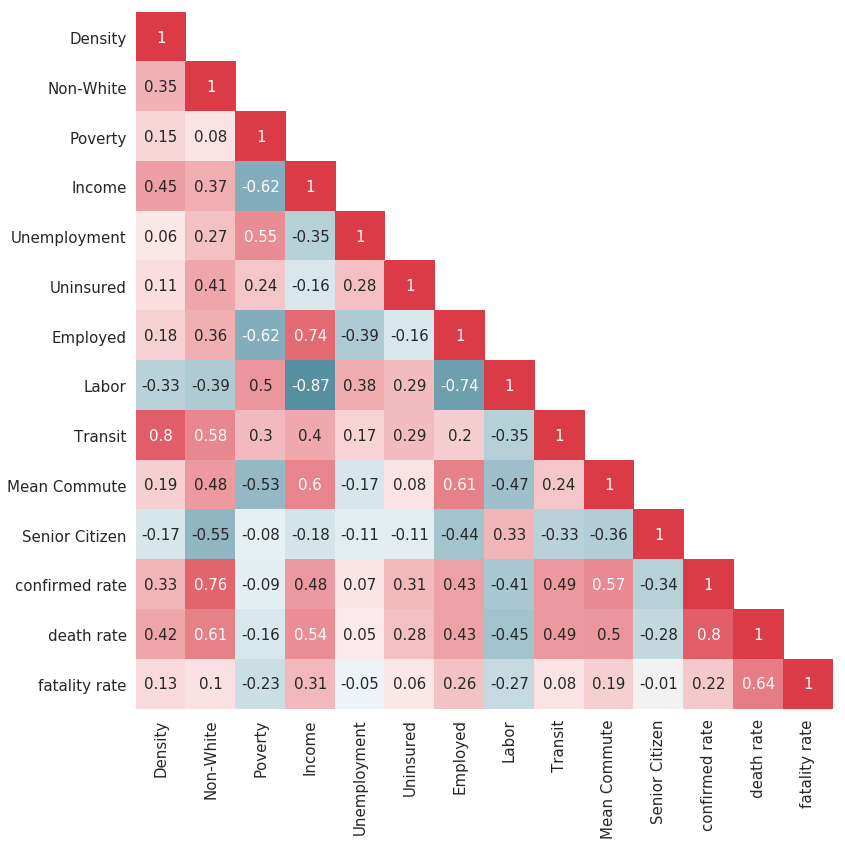

In [42]:
# Generating the plot for the correlation matrix
df_curated_plot = df_density_curated.copy(deep=True)
df_curated_plot_0 = sectorAnalyze(df_curated_plot, df_cut, useDensity=True, type=0, run_BDT=False)
df_curated_plot_1 = sectorAnalyze(df_curated_plot, df_cut, useDensity=True, type=1, run_BDT=False)
df_curated_plot_2 = sectorAnalyze(df_curated_plot, df_cut, useDensity=True, type=2, run_BDT=False)
df_curated_plot_2.drop(df_curated_plot_2[df_curated_plot_2['fatality rate']==np.inf].index, inplace=True)
df_curated_plot = df_curated_plot_1.copy(deep=True)
df_curated_plot['death rate'] = df_curated_plot_0['death rate']
df_curated_plot['fatality rate'] = df_curated_plot_2['fatality rate']
df_curated_plot.Density = 10**df_curated_plot.Density
df_curated_plot['confirmed rate'] = 10**df_curated_plot['confirmed rate'] - 1.
df_curated_plot['death rate'] = 10**df_curated_plot['death rate'] - 1.
df_curated_plot['fatality rate'] = 10**df_curated_plot['fatality rate'] - 1.
fig, ax = makeCorrelationPlot(df_curated_plot)
ax = plt.gca()
ax.tick_params(labelsize=15)
fig.set_size_inches(12,12.)
plt.tight_layout()
plt.savefig('../plots/EC_Corr.png')

Accuracy Score: 72.25% +/- 5.33%


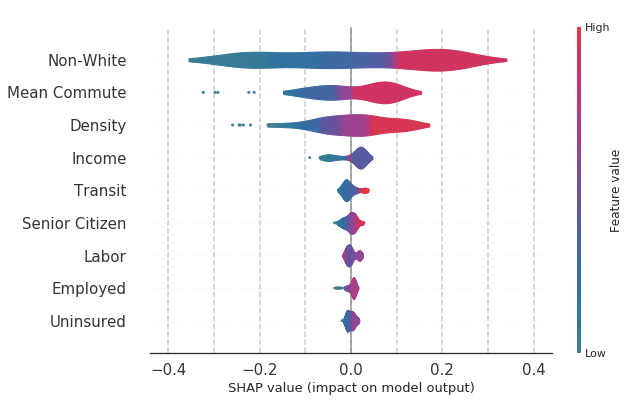

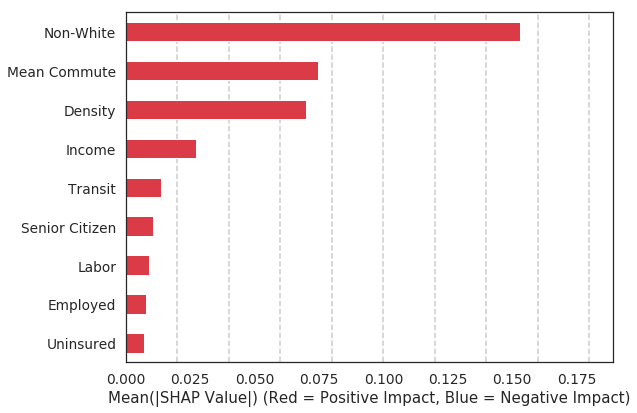

In [43]:
# Analysis of the confirmed case rate
types = ['Poverty','Unemployment']
df_density_curated_1 = df_density_curated.drop(columns=types)
shap_values_01, X_shap_01 = sectorAnalyze(df_density_curated_1, df_cut, useDensity=True, type=1, scale=False, N=500)
abs_shap(shap_values_01, X_shap_01)
plt.tight_layout()
plt.savefig('../plots/EC_CR.png')

Accuracy Score: 30.19% +/- 12.67%


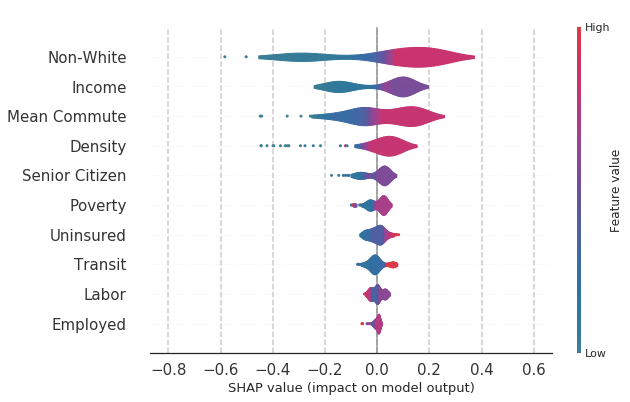

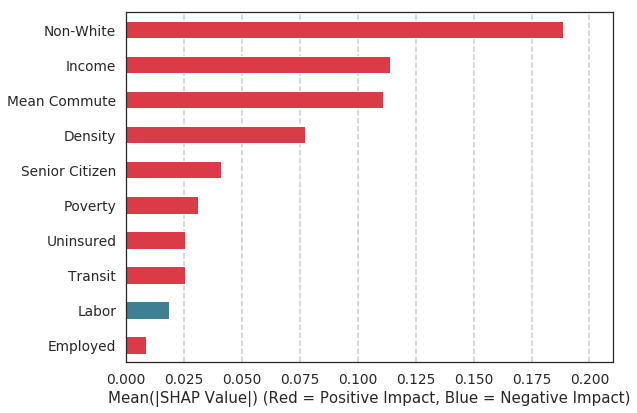

In [44]:
# Analysis of the death rate
types = ['Unemployment']
df_density_curated_0 = df_density_curated.drop(columns=types)
shap_values_00, X_shap_00 = sectorAnalyze(df_density_curated_0, df_cut, useDensity=True, type=0, scale=False, N=500)
abs_shap(shap_values_00, X_shap_00)
plt.tight_layout()
plt.savefig('../plots/EC_DR.png')

## The analysis focusing on the Southern States.

In [11]:
# Filtering out the states to be analysed.
states = ['Alabama', 'Arkansas', 'Florida', 'Georgia', 'Kentucky', 'Louisiana',
          'Mississippi', 'North Carolina', 'Oklahoma', 'South Carolina', 'Tennessee', 'Texas', 'Virginia',
          'West Virginia']

df_density_curated = pd.DataFrame()
for state in states:
    df_density_curated = pd.concat([df_density_curated, df_census_curated[df_census_curated['State'] == state]])
df_density_curated.drop(columns='State', inplace=True)

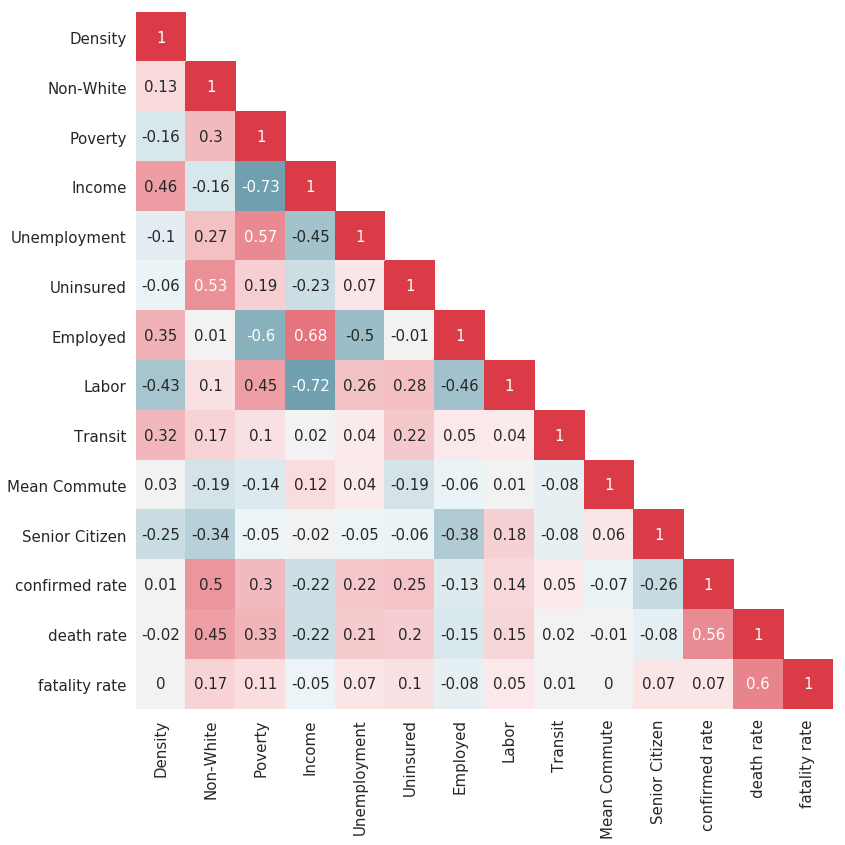

In [12]:
# Generating the plot for the correlation matrix
df_curated_plot = df_density_curated.copy(deep=True)
df_curated_plot_0 = sectorAnalyze(df_curated_plot, df_cut, useDensity=True, type=0, run_BDT=False)
df_curated_plot_1 = sectorAnalyze(df_curated_plot, df_cut, useDensity=True, type=1, run_BDT=False)
df_curated_plot_2 = sectorAnalyze(df_curated_plot, df_cut, useDensity=True, type=2, run_BDT=False)
df_curated_plot_2.drop(df_curated_plot_2[df_curated_plot_2['fatality rate']==np.inf].index, inplace=True)
df_curated_plot = df_curated_plot_1.copy(deep=True)
df_curated_plot['death rate'] = df_curated_plot_0['death rate']
df_curated_plot['fatality rate'] = df_curated_plot_2['fatality rate']
df_curated_plot.Density = 10**df_curated_plot.Density
df_curated_plot['confirmed rate'] = 10**df_curated_plot['confirmed rate'] - 1.
df_curated_plot['death rate'] = 10**df_curated_plot['death rate'] - 1.
df_curated_plot['fatality rate'] = 10**df_curated_plot['fatality rate'] - 1.
fig, ax = makeCorrelationPlot(df_curated_plot)
ax = plt.gca()
ax.tick_params(labelsize=15)
fig.set_size_inches(12.,12.)
plt.tight_layout()
plt.savefig('../plots/SS_Corr.png')

Accuracy Score: 44.34% +/- 2.30%


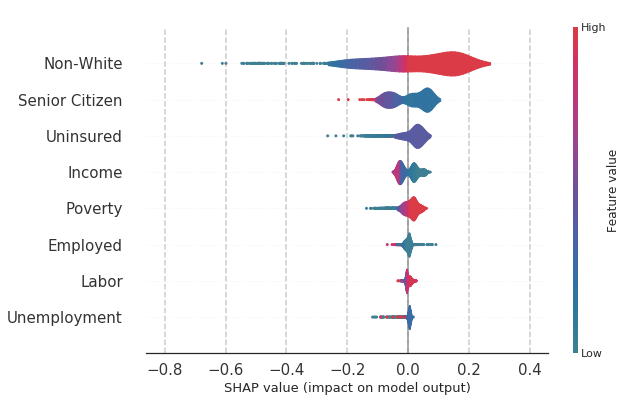

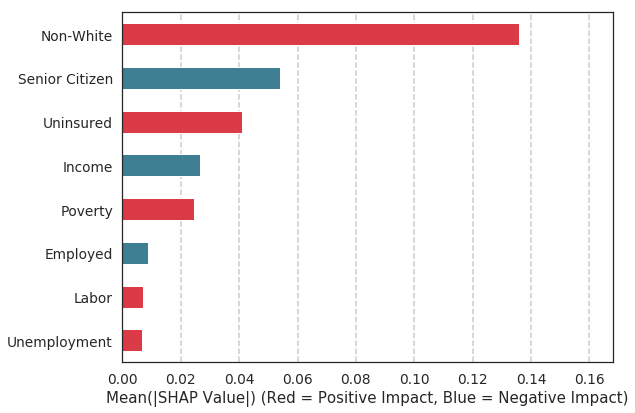

In [13]:
# Analysis of the confirmed case rate
types = ['Mean Commute', 'Transit']
df_density_curated_1 = df_density_curated.drop(columns=types)
shap_values_11, X_shap_11 = sectorAnalyze(df_density_curated_1, df_cut, useDensity=False, type=1, scale=False, N=500)
abs_shap(shap_values_11, X_shap_11)
plt.tight_layout()
plt.savefig('../plots/SS_CR.png')

Accuracy Score: 27.56% +/- 2.39%


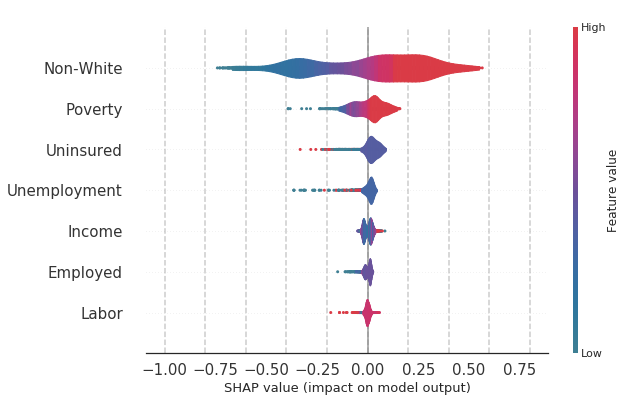

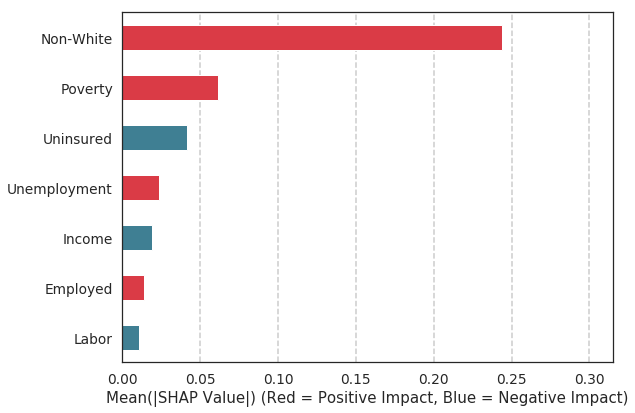

In [14]:
# Analysis of the death rate
types = ['Transit', 'Mean Commute', 'Senior Citizen']
df_density_curated_0 = df_density_curated.drop(columns=types)
shap_values_10, X_shap_10 = sectorAnalyze(df_density_curated_0, df_cut, useDensity=False, type=0, scale=False, N=500)
abs_shap(shap_values_10, X_shap_10)
plt.tight_layout()
plt.savefig('../plots/SS_DR.png')

## The analysis focusing on the states along the west coast.

In [49]:
# Filtering out the states to be analysed.
states = ['California', 'Oregon', 'Washington']

df_density_curated = pd.DataFrame()
for state in states:
    df_density_curated = pd.concat([df_density_curated, df_census_curated[df_census_curated['State'] == state]])
df_density_curated.drop(columns='State', inplace=True)

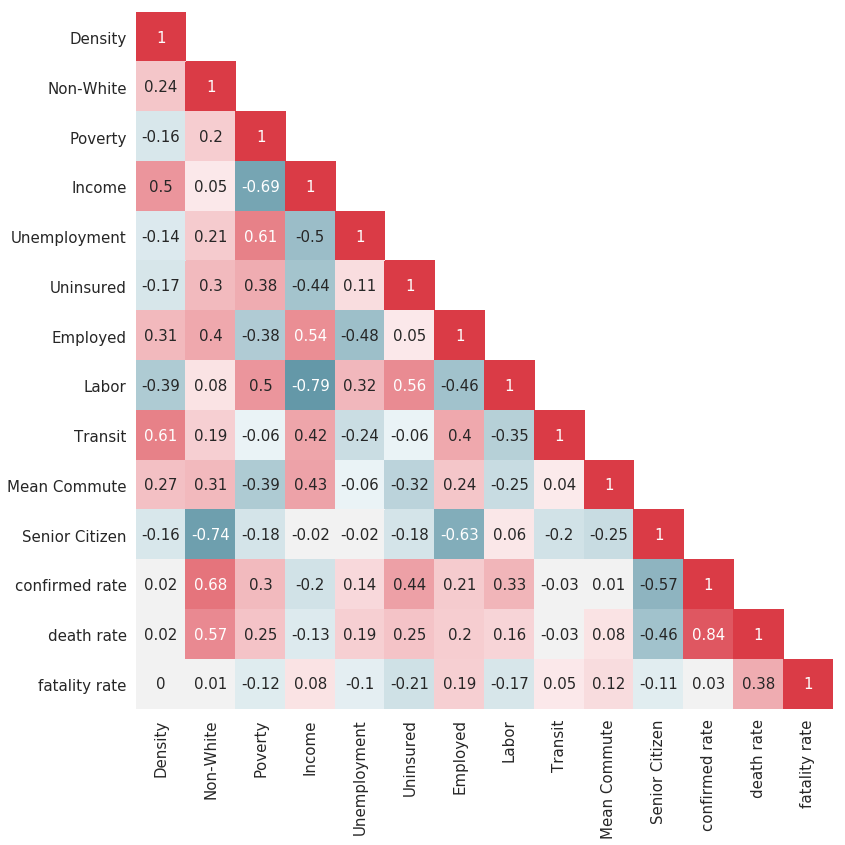

In [50]:
# Generating the plot for the correlation matrix
df_curated_plot = df_density_curated.copy(deep=True)
df_curated_plot_0 = sectorAnalyze(df_curated_plot, df_cut, useDensity=True, type=0, run_BDT=False)
df_curated_plot_1 = sectorAnalyze(df_curated_plot, df_cut, useDensity=True, type=1, run_BDT=False)
df_curated_plot_2 = sectorAnalyze(df_curated_plot, df_cut, useDensity=True, type=2, run_BDT=False)
df_curated_plot_2.drop(df_curated_plot_2[df_curated_plot_2['fatality rate']==np.inf].index, inplace=True)
df_curated_plot = df_curated_plot_1.copy(deep=True)
df_curated_plot['death rate'] = df_curated_plot_0['death rate']
df_curated_plot['fatality rate'] = df_curated_plot_2['fatality rate']
df_curated_plot.Density = 10**df_curated_plot.Density
df_curated_plot['confirmed rate'] = 10**df_curated_plot['confirmed rate'] - 1.
df_curated_plot['death rate'] = 10**df_curated_plot['death rate'] - 1.
df_curated_plot['fatality rate'] = 10**df_curated_plot['fatality rate'] - 1.
fig, ax = makeCorrelationPlot(df_curated_plot)
ax = plt.gca()
ax.tick_params(labelsize=15)
fig.set_size_inches(12.,12.)
plt.tight_layout()
plt.savefig('../plots/WC_Corr.png')

Accuracy Score: 57.56% +/- 8.21%


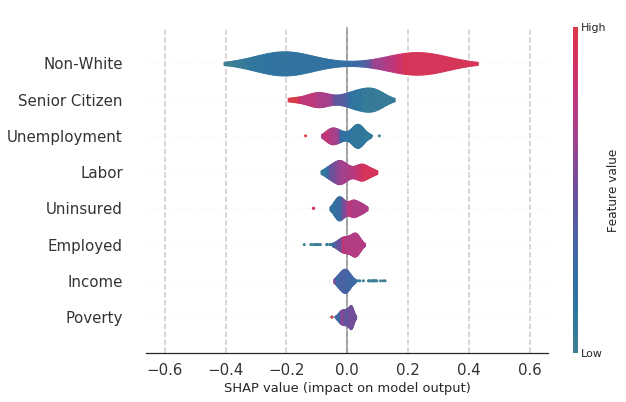

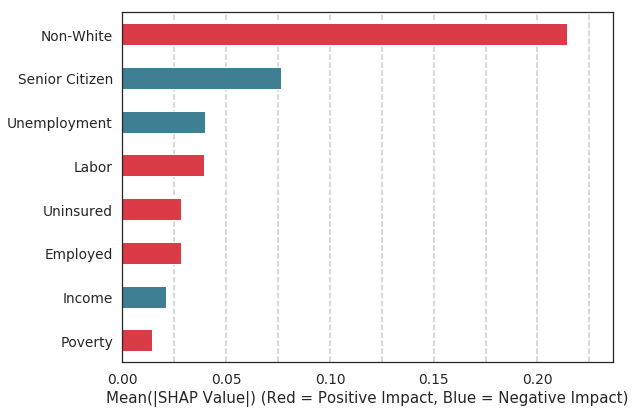

In [51]:
# Analysis of the confirmed case rate
types = ['Transit', 'Mean Commute']
df_density_curated_1 = df_density_curated.drop(columns=types)
shap_values_21, X_shap_21 = sectorAnalyze(df_density_curated_1, df_cut, useDensity=False, type=1, scale=False, N=500)
abs_shap(shap_values_21, X_shap_21)
plt.tight_layout()
plt.savefig('../plots/WC_CR.png')

Accuracy Score: 23.39% +/- 12.02%


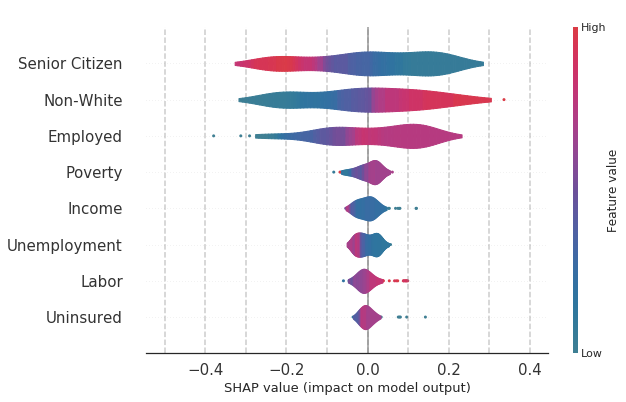

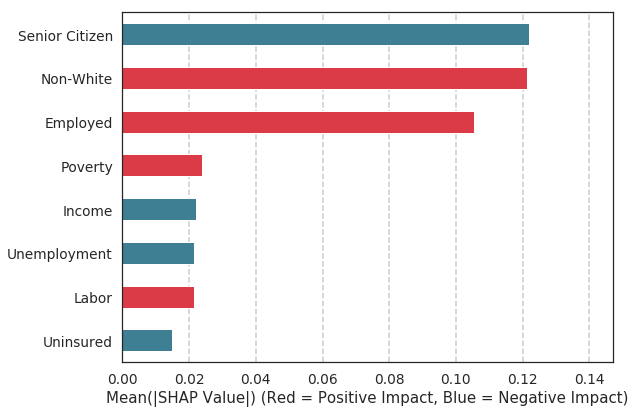

In [52]:
# Analysis of the death rate
types = ['Transit', 'Mean Commute']
df_density_curated_0 = df_density_curated.drop(columns=types)
shap_values_20, X_shap_20 = sectorAnalyze(df_density_curated_0, df_cut, useDensity=False, type=0, scale=False, N=500)
abs_shap(shap_values_20, X_shap_20)
plt.tight_layout()
plt.savefig('../plots/WC_DR.png')

## The analysis for the whole of USA

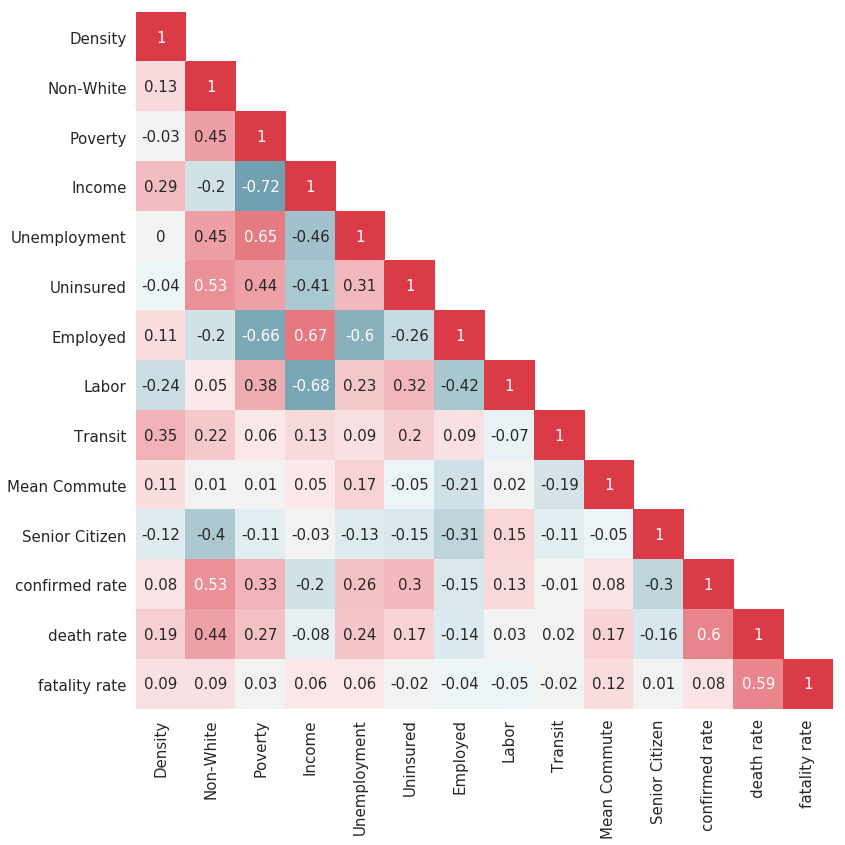

In [53]:
# Generating the plot for the correlation matrix
df_census_curated.drop(columns='State', inplace=True)
df_curated_plot = df_census_curated.copy(deep=True)
df_curated_plot_0 = sectorAnalyze(df_curated_plot, df_cut, useDensity=True, type=0, run_BDT=False)
df_curated_plot_1 = sectorAnalyze(df_curated_plot, df_cut, useDensity=True, type=1, run_BDT=False)
df_curated_plot_2 = sectorAnalyze(df_curated_plot, df_cut, useDensity=True, type=2, run_BDT=False)
df_curated_plot_2.drop(df_curated_plot_2[df_curated_plot_2['fatality rate']==np.inf].index, inplace=True)
df_curated_plot = df_curated_plot_1.copy(deep=True)
df_curated_plot['death rate'] = df_curated_plot_0['death rate']
df_curated_plot['fatality rate'] = df_curated_plot_2['fatality rate']
df_curated_plot.Density = 10**df_curated_plot.Density
df_curated_plot['confirmed rate'] = 10**df_curated_plot['confirmed rate'] - 1.
df_curated_plot['death rate'] = 10**df_curated_plot['death rate'] - 1.
df_curated_plot['fatality rate'] = 10**df_curated_plot['fatality rate'] - 1.
fig, ax = makeCorrelationPlot(df_curated_plot)
ax = plt.gca()
ax.tick_params(labelsize=15)
fig.set_size_inches(12,12.)
plt.tight_layout()
plt.savefig('../plots/USA_Corr.png')

Accuracy Score: 42.22% +/- 1.51%


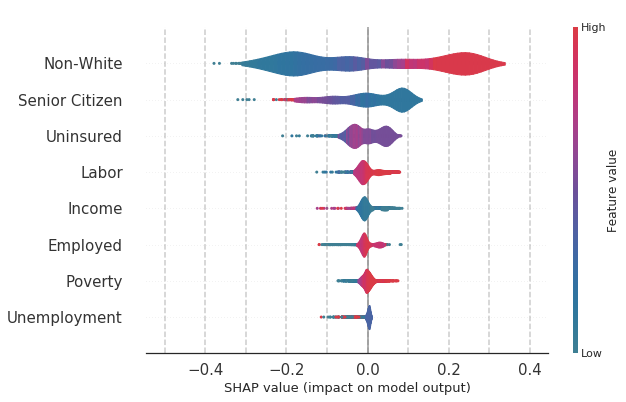

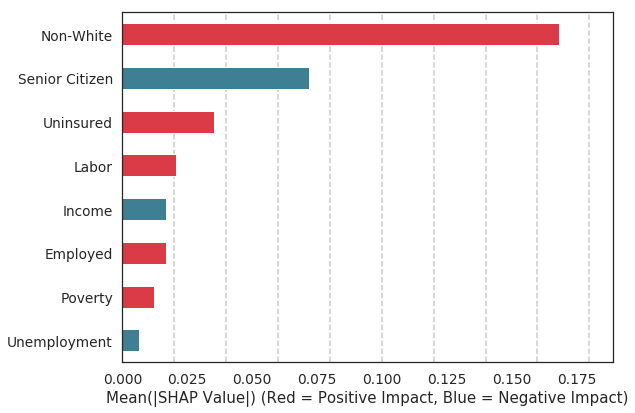

In [54]:
# Analysis for the confirmed case rate
types = ['Transit', 'Mean Commute']
df_census_curated_1 = df_census_curated.drop(columns=types)
shap_values_1, X_shap_1 = sectorAnalyze(df_census_curated_1, df_cut, useDensity=False, type=1, scale=True, N=500)
abs_shap(shap_values_1, X_shap_1)
plt.tight_layout()
plt.savefig('../plots/USA_CR.png')

Accuracy Score: 40.54% +/- 1.50%


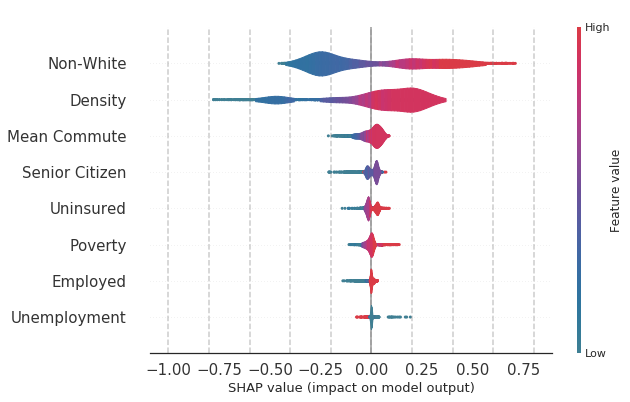

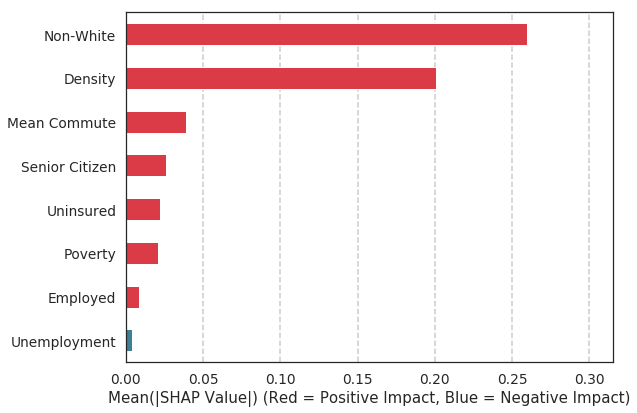

In [55]:
# Analysis for the death rate
types = ['Transit', 'Labor', 'Income']
df_census_curated_0 = df_census_curated.drop(columns=types)
shap_values_0, X_shap_0 = sectorAnalyze(df_census_curated_0, df_cut, useDensity=True, type=0, scale=False, N=500)
abs_shap(shap_values_0, X_shap_0)
plt.tight_layout()
plt.savefig('../plots/USA_DR.png')

## Code for producing Table 1 of the paper

In [ ]:
# For making Table 1 of the paper
df_census_table = pd.DataFrame()
df_census_table['Density'] = 10**df_census['Density']
df_census_table['Race'] = df_census['Non-White']*100.
df_census_table['Poverty'] = df_census['Poverty']*100.
df_census_table['Income'] = df_census['Income/Capita']
df_census_table['Unemployment'] = df_census['Unemployment']*100.
df_census_table['Uninsured'] = df_census['Uninsured']*100.
df_census_table['Employed'] = df_census['Employed']*100.
df_census_table['Labor'] = df_census['Labour']*100.
df_census_table['Transit'] = df_census['Transit']*100.
df_census_table['Mean Commute'] = df_census['MeanCommute']
df_census_table['Senior Citizen'] = df_census['Senior Citizen']*100.
df_census_table['confirmed rate'] = df_curated_plot['confirmed rate']
df_census_table['death rate'] = df_curated_plot['death rate']
df_table = np.round(df_census_table.describe().drop('count'),2)
df_table.to_latex()